# GRAE tests
-> Implemented manually as the import has dependency flaws

# Run Tests

In [1]:
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *
dc = tma("glass.csv", split = "random", verbose = 0)
spud = SPUD()
spud.fit(dc.split_A, dc.split_B, known_anchors=dc.anchors[:10])
spud.get_scores(dc.labels_doubled)

(0.0003493754913092846, 0.4252336448598131, 0.5490654205607477)

In [2]:
# Fit it to a BaseDataset
split_A = BaseDataset(x = dc.split_A, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")

myGraeA = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) #This fit might be expecting labels

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...


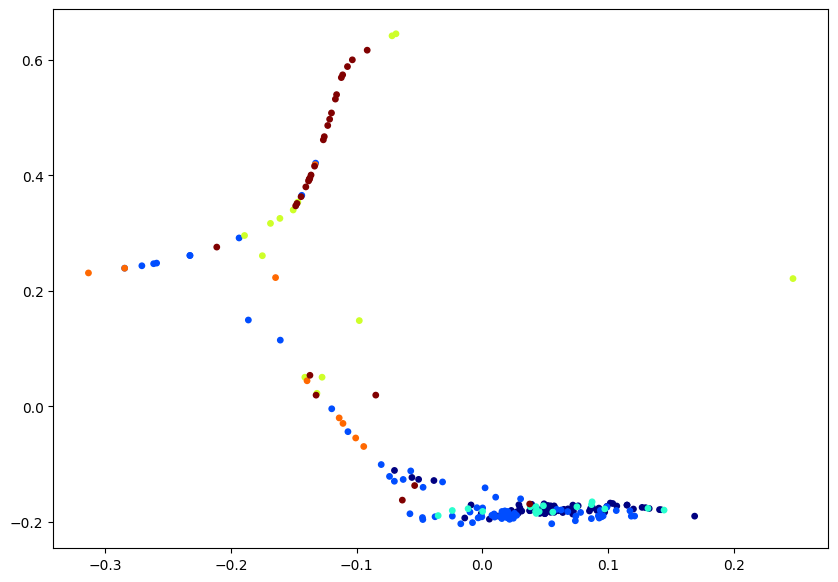

In [3]:
myGraeA.plot(split_A)

### Test with second domain?

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...


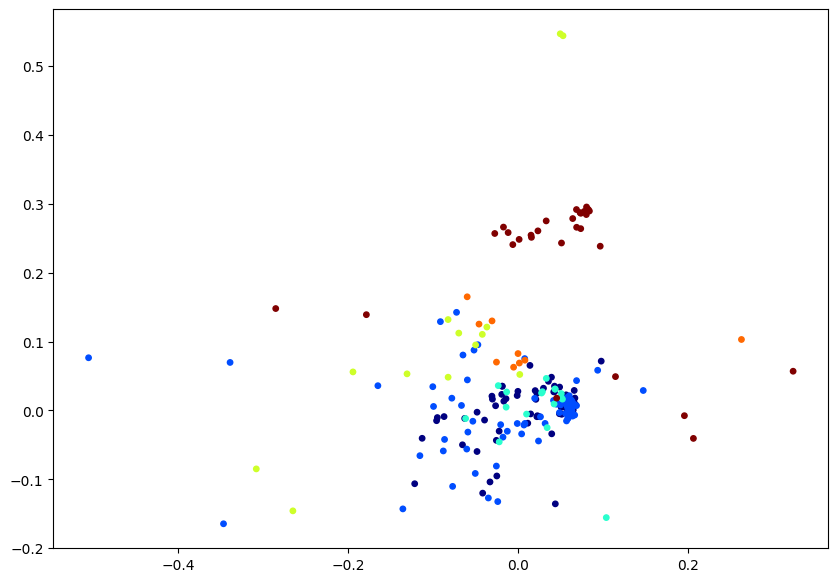

In [4]:
# Fit it to a BaseDataset
split_B = BaseDataset(x = dc.split_B, y = dc.labels, split_ratio = 0.8, random_state = 42, split = "none")

myGraeB = GRAEBase()

# Input data should be an instance of grae.data.BaseDataset
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:]) #This fit might be expecting labels

myGraeB.plot(split_B)

# Test with Embedding broken up

In [1]:
# Testing with GRAE
from Helpers.Grae import *
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
dc = tma(csv_file="iris.csv", split = "random", percent_of_anchors= [0.2], verbose = 4, random_state= 42)
import random

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, r2_score

def train_and_score_models(X_train, X_test, y_train, y_test, task_type="auto"):
    """
    Trains and evaluates KNN and Random Forest models using the specified evaluation metric.

    Parameters:
        X_train: array-like
            Training feature data.
        X_test: array-like
            Testing feature data.
        y_train: array-like
            Training labels or target values.
        y_test: array-like
            Testing labels or target values.
        task_type: str
            The type of task. Can be "regression", "classification", or "auto".
            - "regression": Uses R² score for evaluation.
            - "classification": Uses accuracy score for evaluation.
            - "auto": Automatically detects task type.

    Returns:
        dict: A dictionary containing the scores for KNN and Random Forest models.
    """
    # Detect task type if not explicitly provided
    if task_type == "auto":
        if y_train.dtype.kind in {'i', 'u', 'b'}:  # Integer, unsigned, or boolean
            task_type = "classification"
        else:
            task_type = "regression"

    # Choose model types based on task
    if task_type == "classification":
        knn_model = KNeighborsClassifier()
        rf_model = RandomForestClassifier(random_state=42)
        metric = accuracy_score
    elif task_type == "regression":
        knn_model = KNeighborsRegressor()
        rf_model = RandomForestRegressor(random_state=42)
        metric = r2_score
    else:
        raise ValueError("Invalid task_type. Choose from 'regression', 'classification', or 'auto'.")

    # Train and predict with KNN
    knn_model.fit(X_train, y_train)
    knn_predictions = knn_model.predict(X_test)
    knn_score = metric(y_test, knn_predictions)

    # Train and predict with Random Forest
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    rf_score = metric(y_test, rf_predictions)

    # Return the results
    return {
        "KNN Score": knn_score,
        "Random Forest Score": rf_score,
        "Task Type": task_type
    }

def create_unique_pairs(max_num, num_pairs):
    """
    Generates a list of unique pairs of random numbers.

    Parameters:
        max_num (int): The maximum number (exclusive) for the range of random numbers.
        num_pairs (int): The number of pairs to generate.

    Returns:
        list: A list of unique pairs of random numbers.
    """
    # Ensure there are enough numbers for unique selection
    if num_pairs * 2 > max_num:
        raise ValueError("Not enough unique numbers to create the specified number of pairs.")
    
    # Generate a pool of unique numbers
    random.seed(42)
    numbers = random.sample(range(max_num), num_pairs)
    
    # Create pairs from the list of unique numbers
    pairs = [[numbers[i], numbers[i]] for i in range(0, len(numbers))]
    
    return pairs

MDS initialized with 2 components

 
 
---------------------------       Initalizing class with iris.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


In [2]:
from sklearn.model_selection import train_test_split
X_A_train, X_A_test, y_A_train, y_A_test = train_test_split(dc.split_A, dc.labels, test_size=0.2, random_state=42)
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(dc.split_B, dc.labels, test_size=0.2, random_state=42)

labels_doubled = np.hstack((y_A_train, y_A_test, y_B_train, y_B_test))
train_labels = np.hstack((y_A_train, y_B_train))

In [3]:
#To avoid using the data on the text and Train, we will need to split it
y_A_train == y_B_train

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

In [4]:
#Initialize SPUD Class
spud = SPUD(knn = 3, verbose = 4)

#Fit SPUD
spud.fit(dataA = X_A_train, dataB = X_B_train, known_anchors = create_unique_pairs(len(X_A_train), 10))
spud.get_scores(train_labels, n_components = 2)
# Fit it to a Split A
split_A = BaseDataset(x = X_A_train, y = y_A_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeA = GRAEBase()
# Input data should be an instance of grae.data.BaseDataset
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) #This fit might be expecting labels

pred, mse = myGraeA.score(split_A)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[:len(y_A_train)], pred, y_A_train, y_A_train)}")

myGraeA.plot(split_A)

NameError: name 'SPUD' is not defined

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...
MSE score 0.00026578910183161497 on training data
Classification or R2 score {'KNN Score': 0.9416666666666667, 'Random Forest Score': 0.95, 'Task Type': 'classification'}


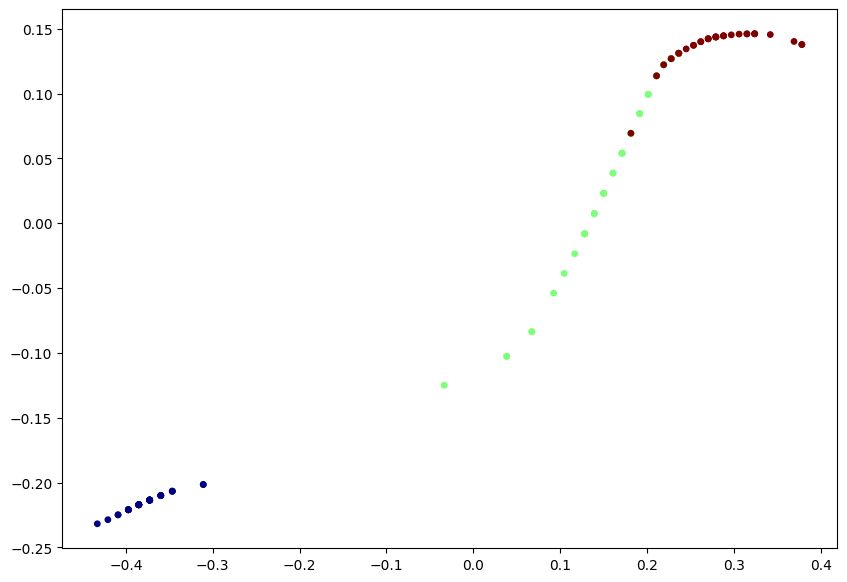

In [ ]:
# Fit it to a Split A
split_B = BaseDataset(x = X_B_train, y = y_B_train, split_ratio = 0.8, random_state = 42, split = "none")

myGraeB = GRAEBase()

# Input data should be an instance of grae.data.BaseDataset
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:]) 
pred, mse = myGraeB.score(split_B)

print(f"MSE score {mse['MSE']} on training data")
print(f"Classification or R2 score {train_and_score_models(spud.emb[len(y_A_train):], pred, y_B_train, y_B_train)}")

myGraeB.plot(split_B)


MSE score 0.00616343691945076 on test data
Classification or R2 score {'KNN Score': 0.9333333333333333, 'Random Forest Score': 0.9666666666666667, 'Task Type': 'classification'}


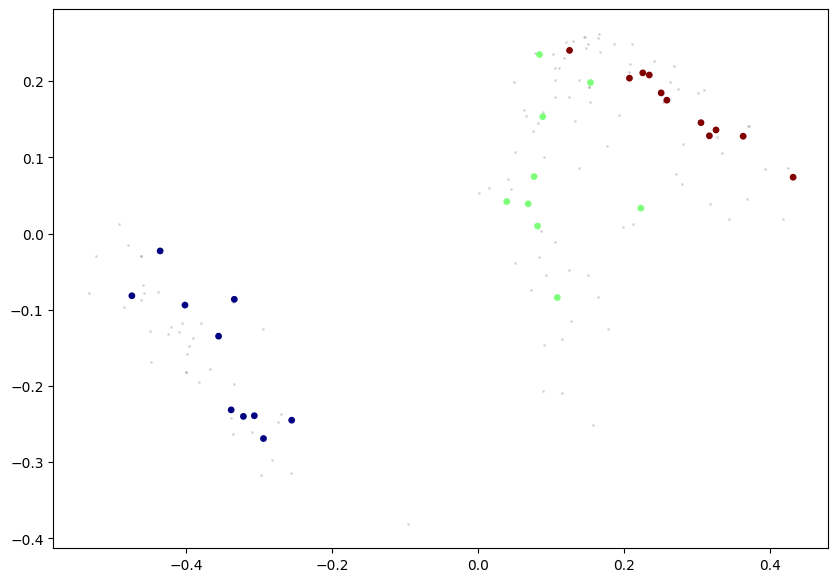

In [ ]:

# Predictions
# Fit it to a Split A
testA = BaseDataset(x = X_A_test, y = y_A_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeA.score(testA)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_A_test)}") # Trained on embedding, predict on the test
myGraeA.plot(x_train = split_A, x_test = testA)

MSE score 0.000365910935215652 on test data
Classification or R2 score {'KNN Score': 1.0, 'Random Forest Score': 0.9666666666666667, 'Task Type': 'classification'}


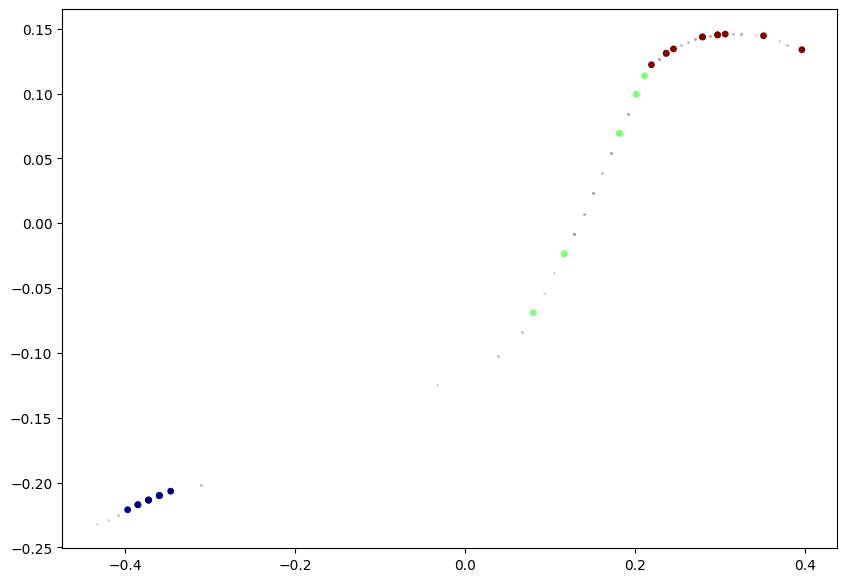

In [ ]:

# Predictions
# Fit it to a Split A
testB = BaseDataset(x = X_B_test, y = y_B_test, split_ratio = 0.8, random_state = 42, split = "none")
pred, mse = myGraeB.score(testB)

print(f"MSE score {mse['MSE']} on test data")
print(f"Classification or R2 score {train_and_score_models(spud.emb, pred, train_labels, y_B_test)}")
myGraeB.plot(x_train = split_B, x_test = testB)
## Making predictions?

In [ ]:
pred, 

(array([[ 0.20155755,  0.09938787],
        [-0.34654254, -0.20667994],
        [ 0.39632887,  0.13380851],
        [ 0.18159471,  0.06934004],
        [ 0.21114238,  0.11365783],
        [-0.37258717, -0.21354291],
        [ 0.08015833, -0.06918722],
        [ 0.23668005,  0.13104233],
        [ 0.18159471,  0.06934004],
        [ 0.11684559, -0.02356162],
        [ 0.23668005,  0.13104233],
        [-0.38512376, -0.21713637],
        [-0.39715782, -0.22099268],
        [-0.37258717, -0.21354291],
        [-0.37258717, -0.21354291],
        [ 0.20155755,  0.09938787],
        [ 0.29717076,  0.1452458 ],
        [ 0.1168456 , -0.02356162],
        [ 0.18159471,  0.06934002],
        [ 0.2793986 ,  0.1436221 ],
        [-0.3597813 , -0.21004663],
        [ 0.21934979,  0.12217692],
        [-0.3597813 , -0.21004663],
        [ 0.2793986 ,  0.14362213],
        [ 0.35120374,  0.1445674 ],
        [ 0.24524245,  0.13441555],
        [ 0.2971708 ,  0.1452458 ],
        [ 0.30613738,  0.145

# Tests From A to B

## Shared Latent Space Autoencoder Architecture Below

Design a two-branch autoencoder:
- One encoder for Domain A and another for Domain B.
- Both encoders map inputs to a shared latent space (z-level).
- Two decoders (one for each domain) reconstruct data from the shared latent space.

In [35]:
# Get data ready
from Main.test_manifold_algorithms import test_manifold_algorithms as tma
from mashspud import SPUD 
from Helpers.Grae import *

dc4 = tma("seeds.csv", split = "turn", verbose = 5)

spud = SPUD()
spud.fit(dc4.split_A, dc4.split_B, known_anchors=dc4.anchors[:10])
spud.get_scores(dc4.labels_doubled)

MDS initialized with 7 components

 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


(0.000151511325471579, 0.9271356783919598, 0.964824120603015)

In [36]:
split_A = BaseDataset(x = dc4.split_A, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
myGraeA = GRAEBase()
myGraeA.fit(split_A, emb=spud.emb[:spud.len_A]) 


split_B = BaseDataset(x = dc4.split_B, y = dc4.labels, split_ratio = 0.8, random_state = 42, split = "none")
myGraeB = GRAEBase()
myGraeB.fit(split_B, emb=spud.emb[spud.len_A:])

       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...
       Fitting GRAE...
           Fitting manifold learning embedding...
           Fitting encoder & decoder...


In [37]:
#Convert A to embedding
data = myGraeA.transform(split_A)

#Convert embedding to B
data_inv = myGraeB.inverse_transform(data)

In [38]:
split_B.numpy()[0].shape

(199, 7)

In [40]:
def reshape_data(data, index):
    if len(data) < 2:
        print(f"Data has less than 2 features")
        return data
    elif len(data) > 2:
        print(f"Data has more than 2 features. Using PCA")
        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        return pca.fit_transform(data)[:, index]
    else:
        return data[:, index]

Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA


Text(0.5, 1.0, 'Domain B Plotted')

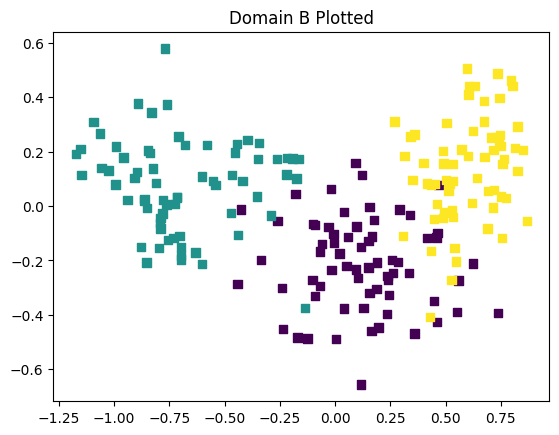

In [41]:
# Plot the embeddings
import matplotlib.pyplot as plt
plt.scatter(x = reshape_data(split_B.numpy()[0], 0), y = reshape_data(split_B.numpy()[0], 1), c = split_B.numpy()[1], marker = "s")
plt.title("Domain B Plotted")

Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA


Text(0.5, 1.0, 'Domain A Plotted')

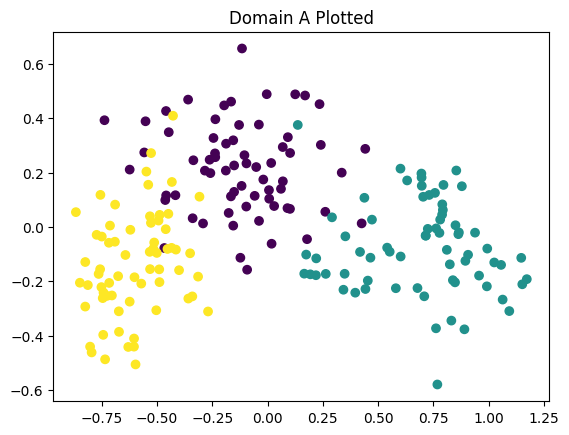

In [42]:
plt.scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1])
plt.title("Domain A Plotted")

0.02783020638890854

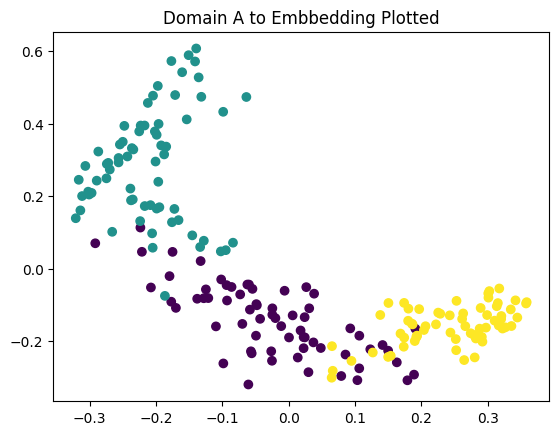

In [43]:
plt.scatter(x = data[:, 0], y = data[:, 1], c = split_A.numpy()[1])
plt.title("Domain A to Embbedding Plotted")

#Print error
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(data, spud.emb[:spud.len_A])

0.06859255291338344

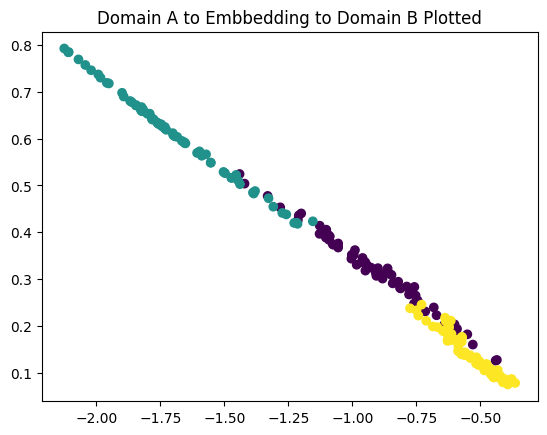

In [44]:
plt.scatter(x = data_inv[:, 0], y = data_inv[:, 1], c = split_A.numpy()[1])
plt.title("Domain A to Embbedding to Domain B Plotted")

#Get the score
from sklearn.metrics import root_mean_squared_error
root_mean_squared_error(data_inv, dc4.split_B)

Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA


Text(0.5, 1.0, 'Domain A Translated ontop of Domain B')

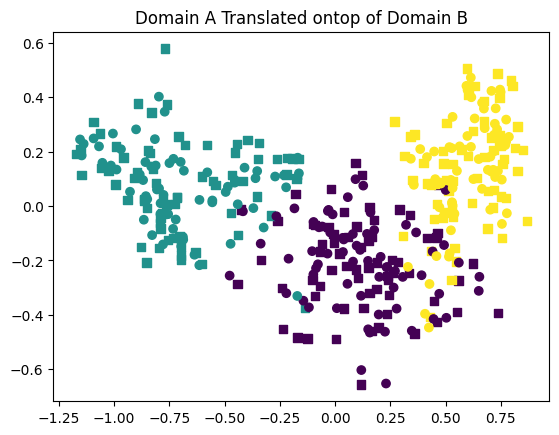

In [47]:
plt.scatter(x = reshape_data(split_B.numpy()[0], 0), y = reshape_data(split_B.numpy()[0], 1), c = split_B.numpy()[1], marker = "s")
plt.scatter(x = reshape_data(data_inv, 0), y = reshape_data(data_inv, 1), c = split_A.numpy()[1])
plt.title("Domain A Translated ontop of Domain B")


Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA
Data has more than 2 features. Using PCA


0.06194324820602425

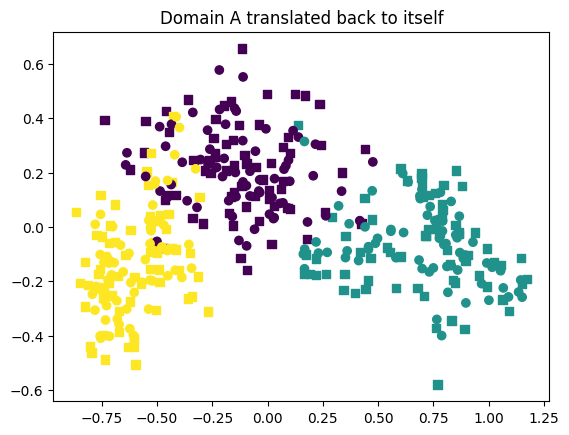

In [50]:
#Convert A to embedding and back
a_reconstructed = myGraeA.inverse_transform(myGraeA.transform(split_A))

plt.scatter(x = reshape_data(split_A.numpy()[0], 0), y = reshape_data(split_A.numpy()[0], 1), c = split_A.numpy()[1], marker = "s")
plt.scatter(x = reshape_data(a_reconstructed, 0), y = reshape_data(a_reconstructed, 1), c = split_A.numpy()[1])
plt.title("Domain A translated back to itself")
root_mean_squared_error(a_reconstructed, dc4.split_A)